**Imports**


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import math
from math import sqrt
import glob 

**Get Pictures**

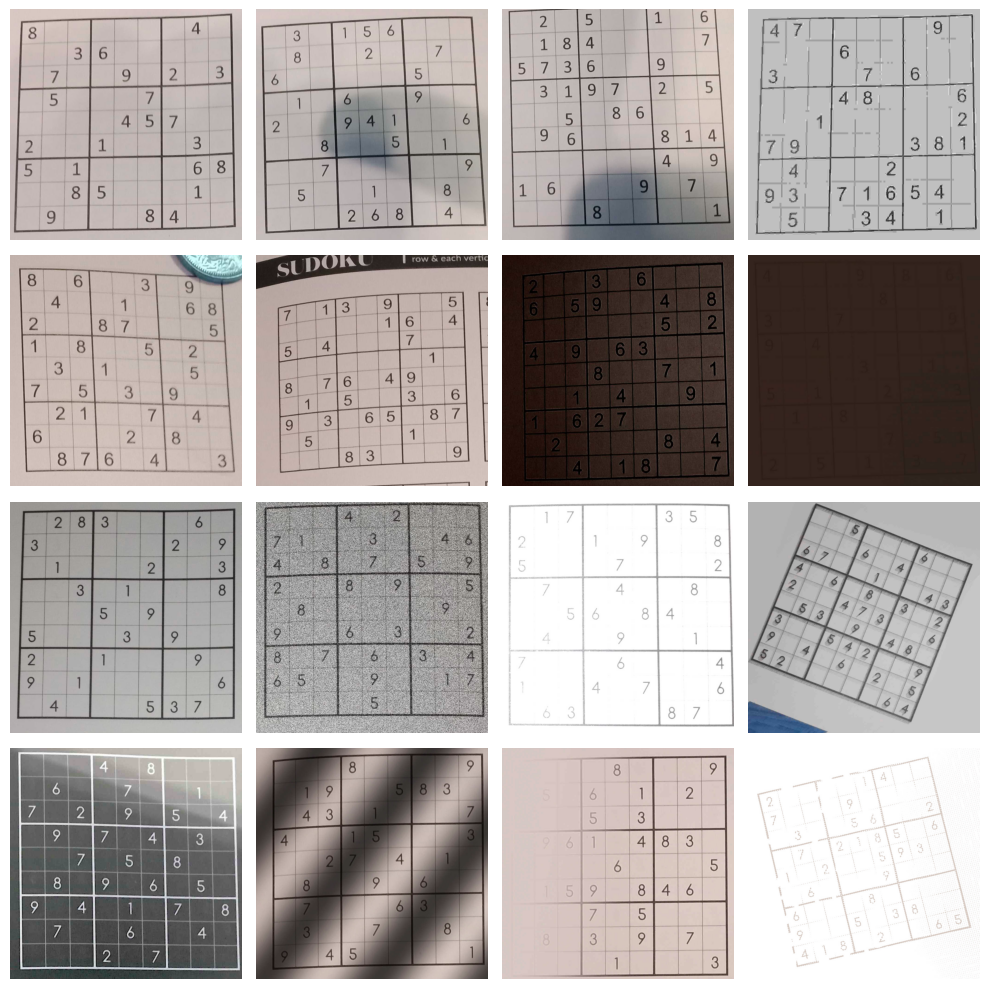

In [2]:
imgs = []
imgs.append(cv2.imread('01-Normal.jpg'))
imgs.append(cv2.imread('02-TheMightyFinger.jpg'))
imgs.append(cv2.imread('03-WhereBorder.jpg'))
imgs.append(cv2.imread('04-CompressoEspresso.jpg'))
imgs.append(cv2.imread('05-Ya3amSheel2elCoinYa3am.jpg'))
imgs.append(cv2.imread('06-FarAndCurved.jpg'))
imgs.append(cv2.imread('07-2elNoor2ata3.jpg'))
imgs.append(cv2.imread('08-MeshShayef7agaYa3am.jpg'))
imgs.append(cv2.imread('09-Normal2.jpg'))
imgs.append(cv2.imread('10-Mal7wFelfel.jpg'))
imgs.append(cv2.imread('11-FlashBang.jpg'))
imgs.append(cv2.imread('12-BrokenPrinter.jpg'))
imgs.append(cv2.imread('13-DarkMode.jpg'))
imgs.append(cv2.imread('14-Sine.jpg'))
imgs.append(cv2.imread('15-GoneWithTheWind.jpg'))
imgs.append(cv2.imread('16-SomethingWentTerriblyWrongHere.jpg'))


NUM_IMAGES = 16
NUM_ROWS_PLOT = 4
NUM_COLS_PLOT = 4

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()


**Remove Yellow Coin**

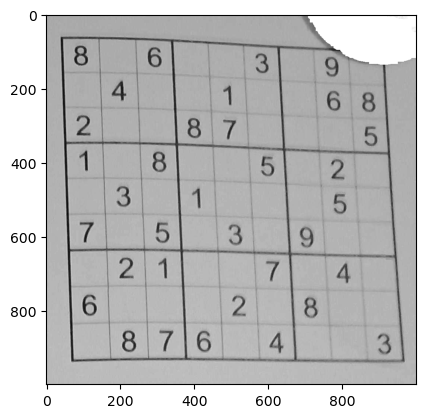

In [3]:
lowerValues = np.array([10, 50, 70])
upperValues = np.array([35, 255, 255])
imgsWithoutCoins = []
imgIndexsWithCoins = []
for i in range(0, NUM_IMAGES):
    grayscaleImage = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2GRAY)
    hsvImage = cv2.cvtColor(imgs[i], cv2.COLOR_BGR2HSV)
    coinMask = cv2.inRange(hsvImage, lowerValues, upperValues)

    # Increase the size of the mask using dilation
    dilateKernel = np.ones((15, 15), np.uint8)
    coinMask = cv2.dilate(coinMask, dilateKernel, iterations=1)

    morphKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    coinMask = cv2.morphologyEx(coinMask, cv2.MORPH_CLOSE, morphKernel, None, None, 1, cv2.BORDER_REFLECT101)

    if cv2.countNonZero(coinMask) > 30000:
        imgIndexsWithCoins.append(i)
        imgWithoutCoins = cv2.add(grayscaleImage, coinMask)
    else:
        # If the coin mask is smaller than the threshold, use the original grayscale image
        imgWithoutCoins = grayscaleImage

    imgsWithoutCoins.append(imgWithoutCoins)

plt.imshow(imgsWithoutCoins[4], cmap='gray')
plt.show()

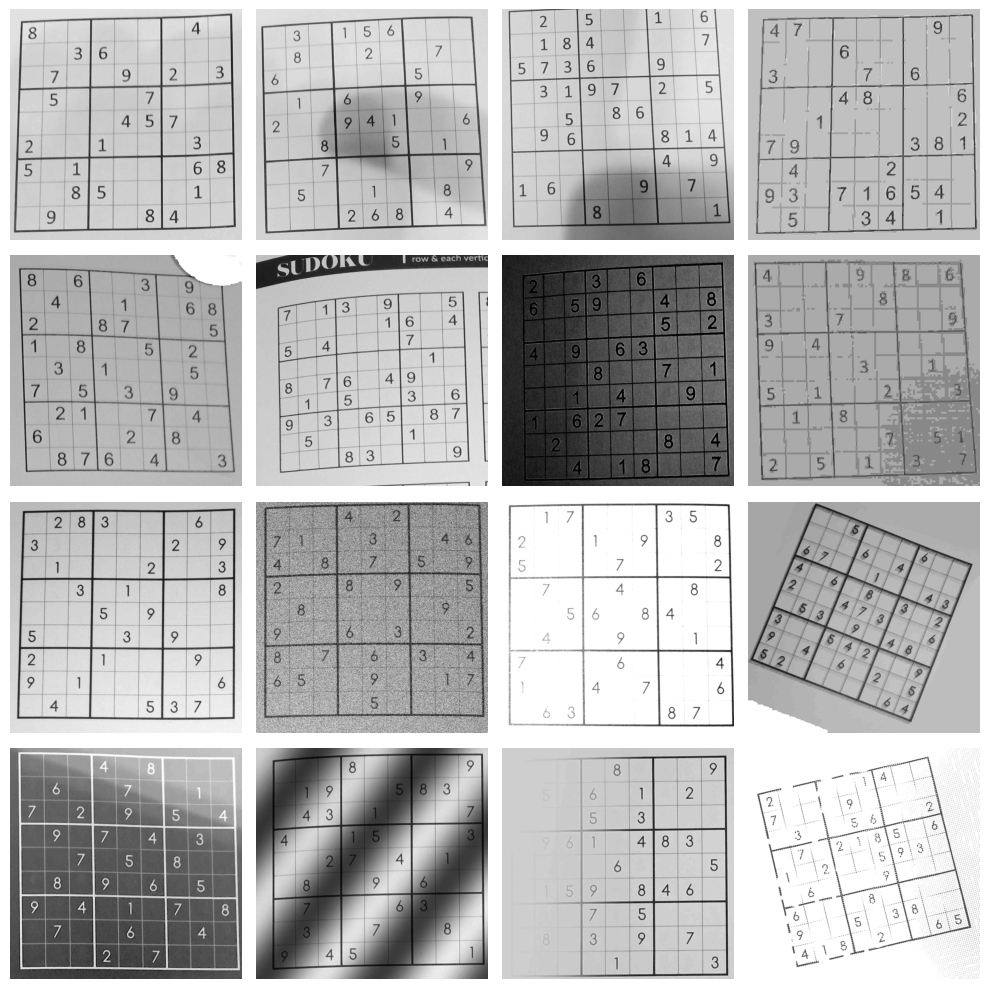

In [4]:
grayImgs = []
zeroImgs = []
for i in range(0,NUM_IMAGES):

  if len(imgsWithoutCoins[i].shape) == 2:  # Single-channel image
      grayImgs.append(imgsWithoutCoins[i])
  else:  # Multi-channel image, convert to grayscale
      grayImgs.append(cv2.cvtColor(imgsWithoutCoins[i], cv2.COLOR_BGR2GRAY))
        
  zeroImgs.append(np.zeros((grayImgs[i].shape),np.uint8))

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(grayImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**Remove Periodic Noise Using Fourier Transform**

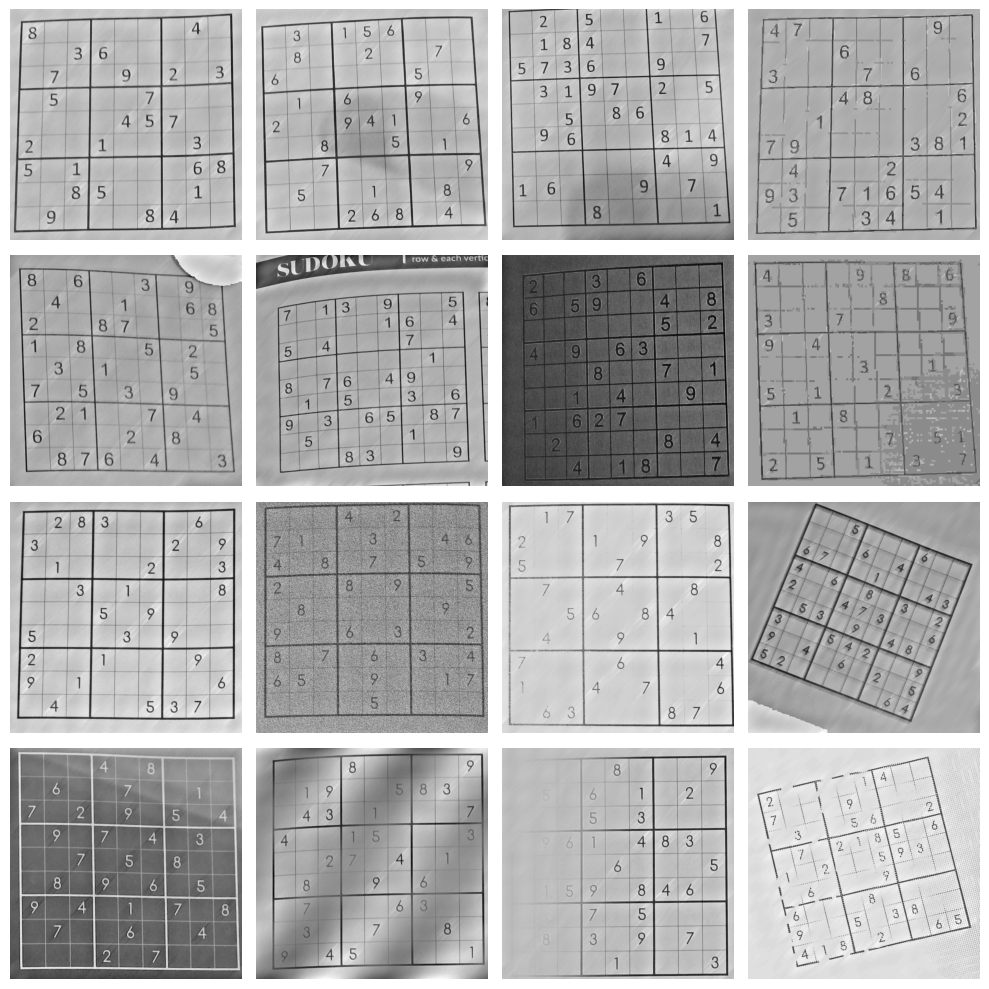

In [5]:
def distance(point1, point2):
    return sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


def butterworthLP(D0, imgShape, n):
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (rows / 2, cols / 2)
    for x in range(cols):
        for y in range(rows):
            base[y, x] = 1 / (1 + (distance((y, x), center) / D0) ** (2 * n))
    return base

frequencyFilteredImgs = []
for imgNum in range(0,NUM_IMAGES):
    fourier_transform = np.fft.fft2(grayImgs[imgNum])
    center_shift = np.fft.fftshift(fourier_transform)

    fourier_noisy = 20 * np.log(np.abs(center_shift))

    rows, cols = grayImgs[imgNum].shape
    crow, ccol = rows // 2, cols // 2

    for x in range(0, rows):
      for y in range(0, cols):
        if (x == y):
          for i in range(0, 10):
            center_shift[x - i, y] = 1


    filtered = center_shift * butterworthLP(80, grayImgs[imgNum].shape, 10)

    f_shift = np.fft.ifftshift(center_shift)
    denoised_image = np.fft.ifft2(f_shift)
    frequencyFilteredImgs.append(np.real(denoised_image))


    
min_value = np.min([np.min(array) for array in frequencyFilteredImgs])
max_value = np.max([np.max(array) for array in frequencyFilteredImgs])

# Scale and convert each array to uint8
frequencyFilteredImgs = [(array - min_value) / (max_value - min_value) * 255 for array in frequencyFilteredImgs]
frequencyFilteredImgs = [np.round(scaled_array).astype(np.uint8) for scaled_array in frequencyFilteredImgs]


fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(frequencyFilteredImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

# **Preprocessing**

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10632\292574438.py:20: RuntimeWarning: invalid value encountered in divide
  div = np.float32(threshImgs[i])/(close)
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10632\292574438.py:21: RuntimeWarning: invalid value encountered in cast
  closedImgs.append(np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX)))
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10632\292574438.py:24: RuntimeWarning: invalid value encountered in divide
  div = np.float32(threshImgsWithoutDilate[i])/(close)
C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10632\292574438.py:25: RuntimeWarning: invalid value encountered in cast
  threshImgsWithoutDilate[i] = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))


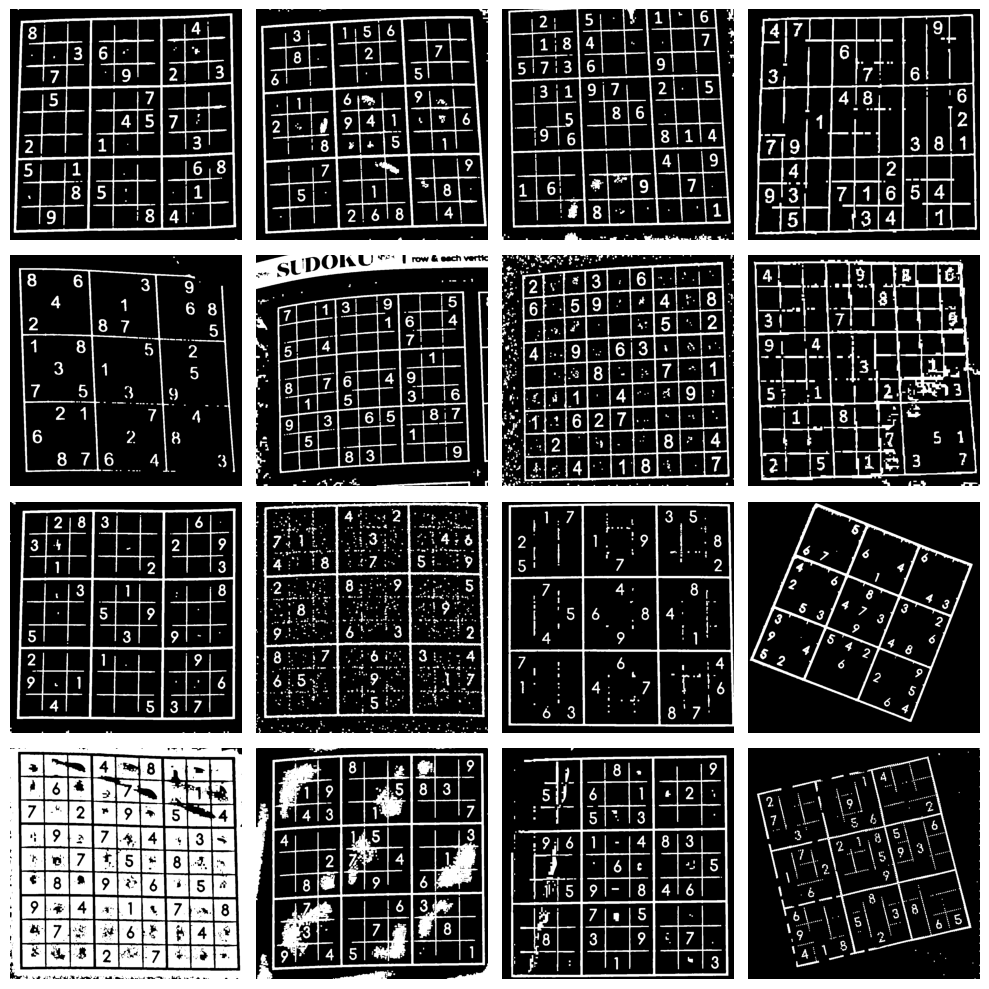

In [6]:
blurImgs = []
threshImgs = []
threshImgsWithoutDilate = []
for i in range(NUM_IMAGES):
  blurImgs.append(cv2.GaussianBlur(grayImgs[i],(5,5),0))
  if i in imgIndexsWithCoins:
      _, thresh_img = cv2.threshold(blurImgs[i], 125, 255, cv2.THRESH_BINARY_INV)
      kernel2 = np.ones((15, 15), np.uint8)
      kernel3 = np.ones((3, 3), np.uint8)
      threshImgs.append(cv2.dilate(thresh_img, kernel2, iterations=1))
      threshImgsWithoutDilate.append(cv2.dilate(thresh_img, kernel3, iterations=1))
  else:
      threshImgs.append(cv2.adaptiveThreshold(blurImgs[i],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,131,1))
      threshImgsWithoutDilate.append(cv2.adaptiveThreshold(blurImgs[i],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,131,1))

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
closedImgs = []
for i in range(NUM_IMAGES):
  close = cv2.morphologyEx(threshImgs[i], cv2.MORPH_CLOSE, kernel)
  div = np.float32(threshImgs[i])/(close)
  closedImgs.append(np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX)))

  close = cv2.morphologyEx(threshImgsWithoutDilate[i], cv2.MORPH_CLOSE, kernel)
  div = np.float32(threshImgsWithoutDilate[i])/(close)
  threshImgsWithoutDilate[i] = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))

  kernel = np.ones((5, 5), np.uint8)
  closedImgs[i] = cv2.erode(closedImgs[i], kernel, iterations=1)
  closedImgs[i] = cv2.dilate(closedImgs[i], kernel, iterations=1)

  kernel = np.ones((5, 5), np.uint8)
  threshImgsWithoutDilate[i] = cv2.erode(threshImgsWithoutDilate[i], kernel, iterations=1)
  threshImgsWithoutDilate[i] = cv2.dilate(threshImgsWithoutDilate[i], kernel, iterations=1)

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(threshImgsWithoutDilate[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**Invert Image if the white pixels number is too big**

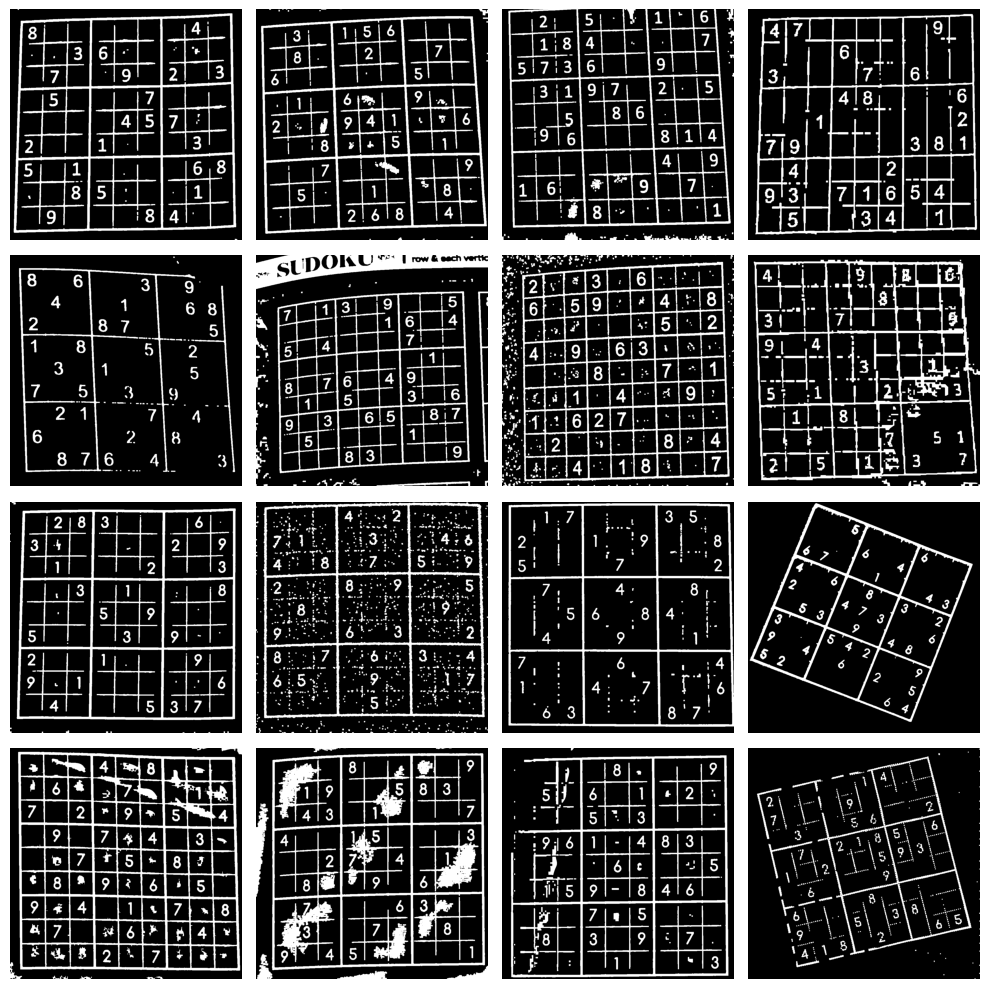

In [7]:
for i in range(0,NUM_IMAGES):
    _, binary_mask = cv2.threshold(closedImgs[i], 128, 255, cv2.THRESH_BINARY)

    # Count the number of white and black pixels in the binary mask
    num_white_pixels = np.sum(binary_mask == 255)
    num_black_pixels = np.sum(binary_mask == 0)
    # Check if dark pixels are more than white pixels
    if num_black_pixels < num_white_pixels:
        closedImgs[i] = cv2.bitwise_not(closedImgs[i])
        frequencyFilteredImgs[i] = cv2.bitwise_not(frequencyFilteredImgs[i])
        threshImgsWithoutDilate[i] = cv2.bitwise_not(threshImgsWithoutDilate[i])
        
    if num_black_pixels/num_white_pixels < 3.8:
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closedImgs[i], connectivity=8)
        filtered_mask = np.zeros_like(closedImgs[i])
        filtered_mask2 = np.zeros_like(threshImgsWithoutDilate[i])
        min_component_size = 300
            
        for label in range(1, num_labels):
                # Check the size of the connected component
                if stats[label, cv2.CC_STAT_AREA] >= min_component_size:
                    # Retain the pixels belonging to this connected component
                    filtered_mask[labels == label] = 255
                    filtered_mask2[labels == label] = 255
            
        closedImgs[i] = cv2.bitwise_and(closedImgs[i], closedImgs[i], mask=filtered_mask)
    
        threshImgsWithoutDilate[i] = cv2.bitwise_and(threshImgsWithoutDilate[i], threshImgsWithoutDilate[i], mask=filtered_mask2)
    

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(threshImgsWithoutDilate[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**Apply Frequncy Filter For The Most Needed Image**

In [8]:
maxFilteredImageI = -1
maxFilteredImage = None
maxValue = -1
for i in range(0,NUM_IMAGES):
    num_black_pixels_grey_image = np.sum(closedImgs[i] == 0)
    _, thresh_img = cv2.threshold(frequencyFilteredImgs[i], 113, 255, cv2.THRESH_BINARY_INV)
    num_black_pixels_frequency_image = np.sum(thresh_img == 0)
    value = num_black_pixels_frequency_image/num_black_pixels_grey_image
    if value > maxValue:
        maxValue = value
        maxFilteredImage = thresh_img
        maxFilteredImageI = i
closedImgs[maxFilteredImageI] = maxFilteredImage
threshImgsWithoutDilate[maxFilteredImageI] = maxFilteredImage


**View All Sudukos After Preprocessing**

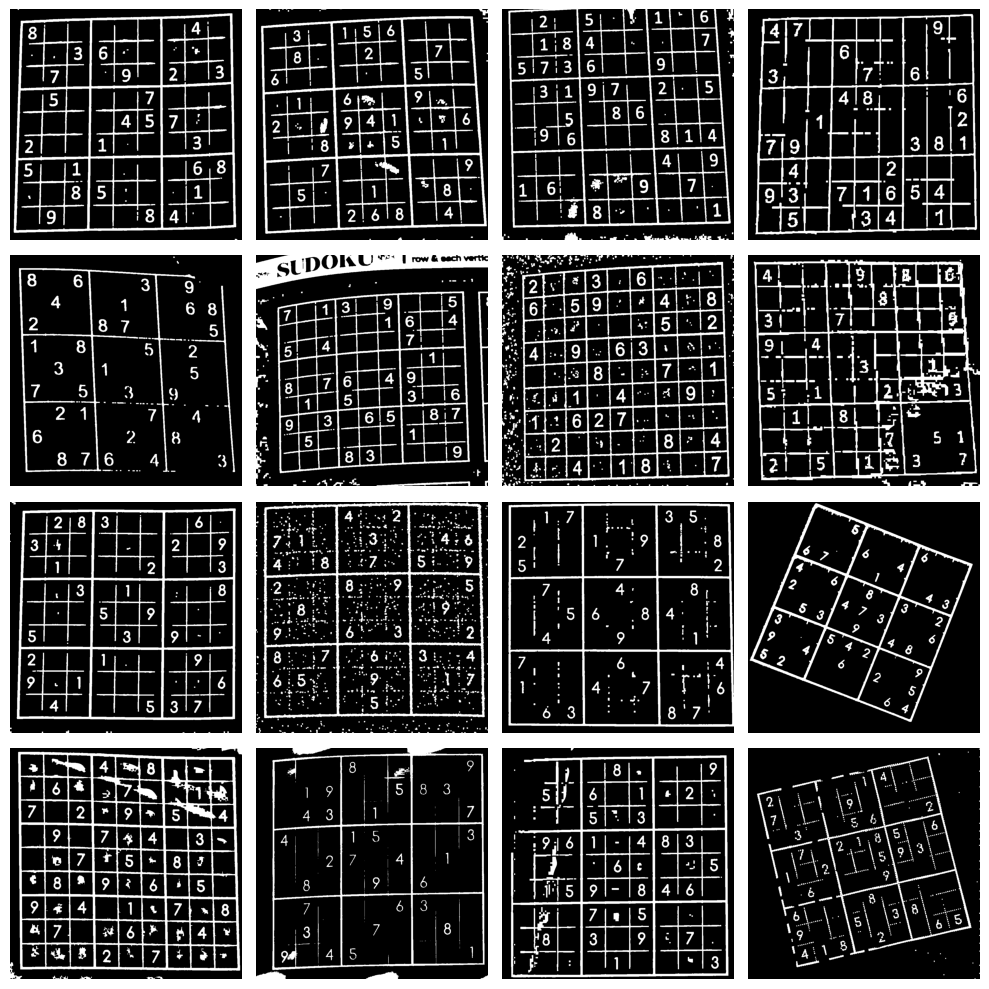

In [9]:
fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    try:
      if i < NUM_IMAGES:
          axes[i].imshow(threshImgsWithoutDilate[i], cmap='gray')
          axes[i].axis('off')
    except:
      pass
plt.tight_layout()
plt.show()

**Contours**

C:\Users\Ahmad\AppData\Local\Temp\ipykernel_10632\3437324340.py:51: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(cv2.boxPoints(rotated_rect))


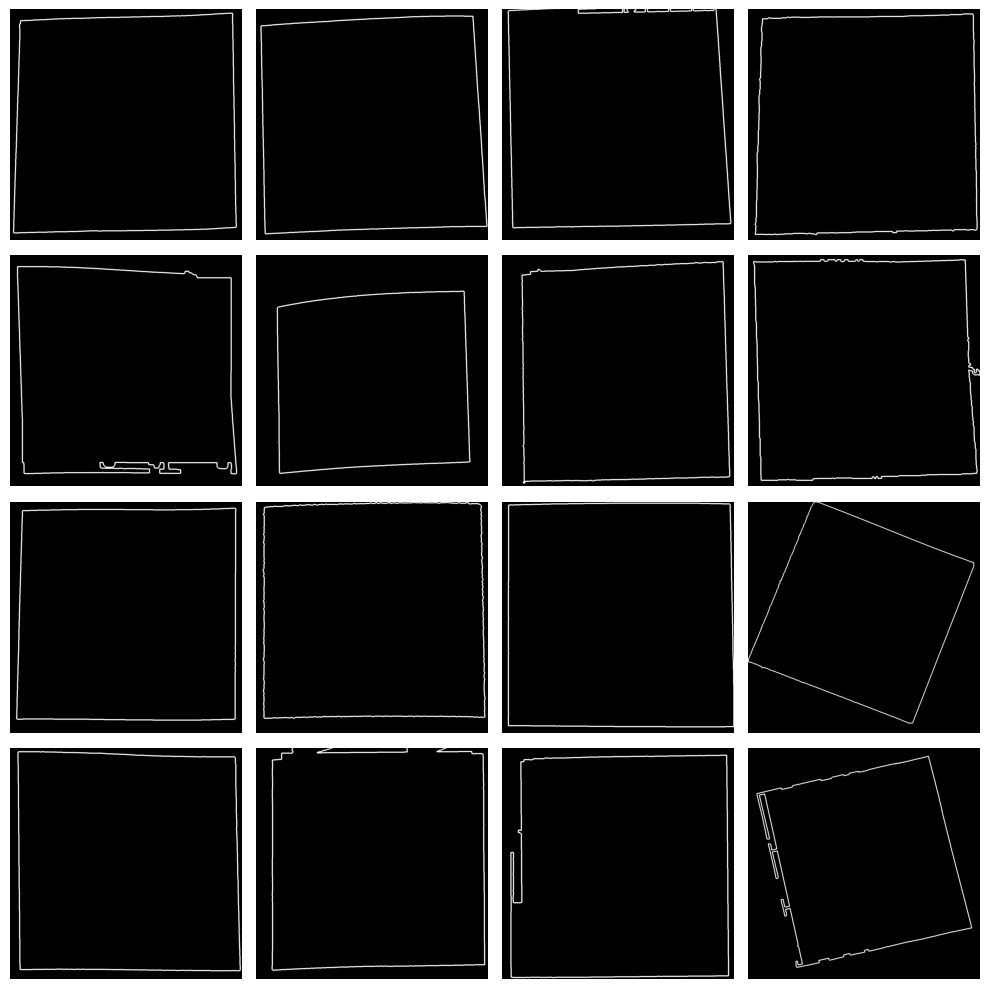

In [10]:
contourImgs = []
bestCnts = []
finalContourImgs = []
finalBestCnts = []
rotatedRects = []

for i in range(NUM_IMAGES):
    contourImgs.append(np.zeros((closedImgs[i].shape), np.uint8))
    contour, hier = cv2.findContours(closedImgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    max_area = 0
    bestCnts.append(None)

    for cnt in contour:
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            bestCnts[i] = cnt
        cv2.drawContours(contourImgs[i], [cnt], 0, 255, 2)

    if max_area < 400000:
      # Do some operations before getting contour as there are probably gaps in the image
      median = cv2.medianBlur(grayImgs[i], 9)
      cannyImg = cv2.Canny(median, 50, 150)
      kernel2 = np.ones((15, 15), np.uint8)
      dilated_edges = cv2.dilate(cannyImg, kernel2, iterations=4)
      eroded_edges = cv2.erode(dilated_edges, kernel2, iterations=2)
      contour, hier = cv2.findContours(eroded_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      max_area = 0
      for cnt in contour:
          area = cv2.contourArea(cnt)
          if area > max_area:
              max_area = area
              bestCnts[i] = cnt

    # Store rotated rectangle in the array
    if bestCnts[i] is not None:
        epsilon = 0.01 * cv2.arcLength(bestCnts[i], True)
        approx = cv2.approxPolyDP(bestCnts[i], epsilon, True)

        rotated_rect = cv2.minAreaRect(approx)
        rect_center, rect_size, rect_angle = rotated_rect
        rect_size = (rect_size[0] - 2 * 25, rect_size[1] - 2 * 50)
        #rect_center = (rect_center[0] - 10, rect_center[1] + 5)
        rect_size = (rect_size[0] + 5, rect_size[1] + 5)
        rotated_rect = (rect_center, rect_size, rect_angle)
        rotatedRects.append(rotated_rect)

    # Draw rotated rectangle
    if bestCnts[i] is not None:
        box = np.int0(cv2.boxPoints(rotated_rect))
        cv2.drawContours(contourImgs[i], [box], 0, 255, 2)
        finalContourImgs.append(np.zeros((closedImgs[i].shape), np.uint8))
        contourFinal, hierFinal = cv2.findContours(contourImgs[i], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        max_areaFinal = 0
        finalBestCnts.append(None)

        for cnt2 in contourFinal:
            areaFinal = cv2.contourArea(cnt2)
            if areaFinal > max_areaFinal:
                max_areaFinal = areaFinal
                finalBestCnts[i] = cnt2
        cv2.drawContours(finalContourImgs[i],[finalBestCnts[i]],0,255,3)


fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    if i < NUM_IMAGES:
        axes[i].imshow(finalContourImgs[i], cmap='gray')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

**Prepare For Prespective Transform**

In [11]:
def sortPoints(points):
  points = points.reshape((4,2))
  pointsSorted = np.zeros((4,1,2), dtype = np.int32)
  addPoints = points.sum(1)
  pointsSorted[0] = points[np.argmin(addPoints)]
  pointsSorted[3] = points[np.argmax(addPoints)]
  diffPoints = np.diff(points, axis=1)
  pointsSorted[1] = points[np.argmin(diffPoints)]
  pointsSorted[2] = points[np.argmax(diffPoints)]
  return pointsSorted

In [12]:
pts1 = []
pts2 = []
for i in range(NUM_IMAGES):
  arcLength = cv2.arcLength(finalBestCnts[i],True)
  approx = cv2.approxPolyDP(finalBestCnts[i],0.02*arcLength,True)
  try:
    approxNew = sortPoints(approx)

    width,height = 450,450

    pts1.append(np.float32(approxNew))
    pts2.append(np.float32([[0,0], [width,0], [0,height], [width,height]]))
  except:
    pass


**Presepctive Transform**

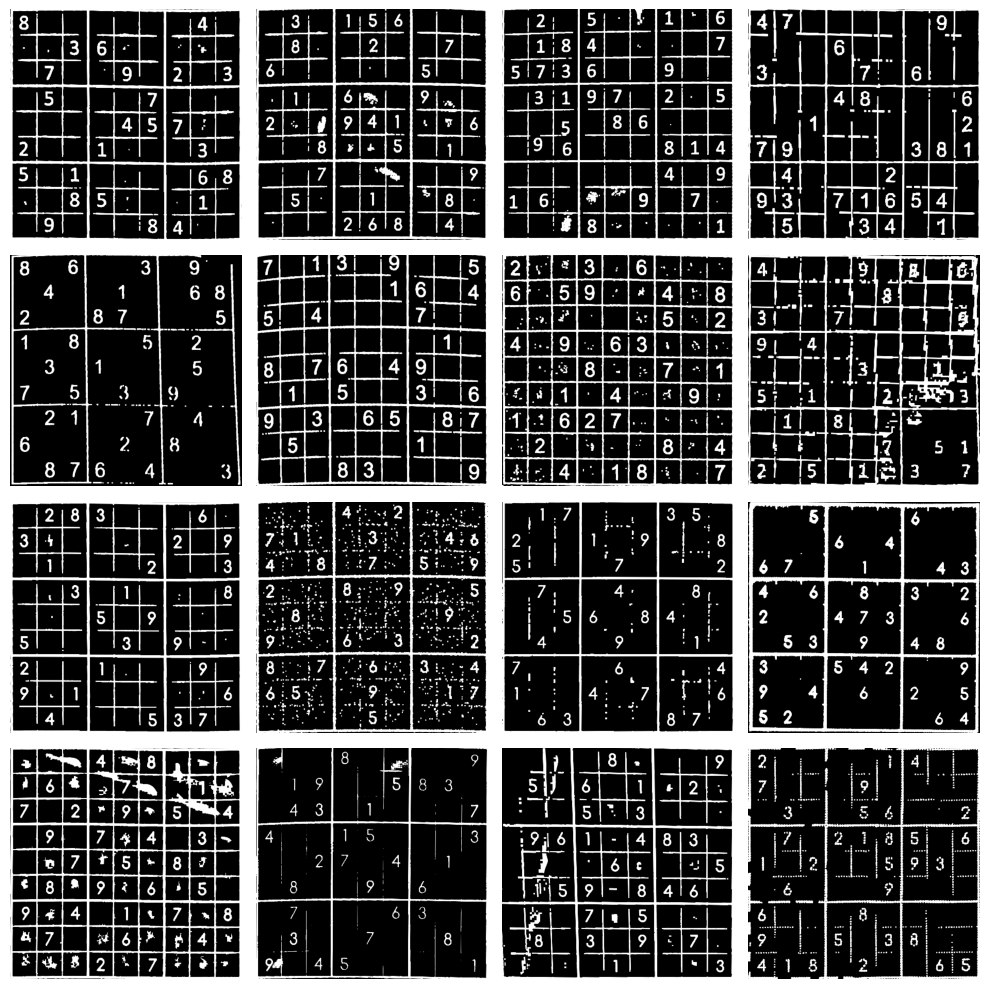

In [13]:
perspectiveImgs = []
for i in range(NUM_IMAGES):
  try:
    invertedImg = cv2.bitwise_not(threshImgsWithoutDilate[i])
    matrix = cv2.getPerspectiveTransform(pts1[i],pts2[i])
    perspectiveImgs.append(cv2.warpPerspective(threshImgsWithoutDilate[i],matrix,(width,height)))
  except:
    perspectiveImgs.append(0)

fig, axes = plt.subplots(NUM_ROWS_PLOT, NUM_COLS_PLOT, figsize=(10, 10))
axes = axes.flatten()
for i in range(NUM_IMAGES):
    try:
      if i < NUM_IMAGES:
          axes[i].imshow(perspectiveImgs[i], cmap='gray')
          axes[i].axis('off')
    except:
      pass
plt.tight_layout()
plt.show()

**Seperate the Number Tiles**

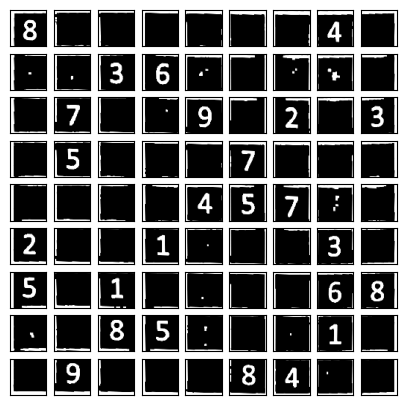

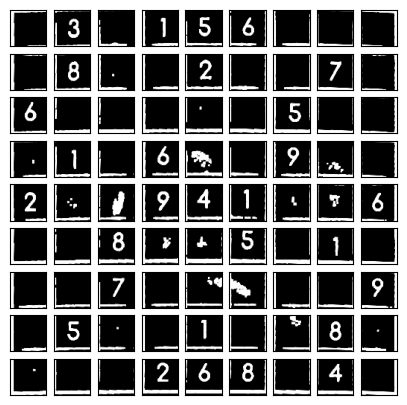

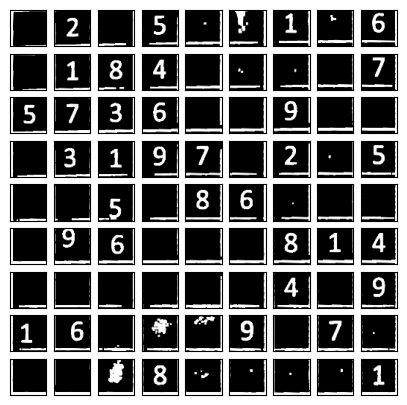

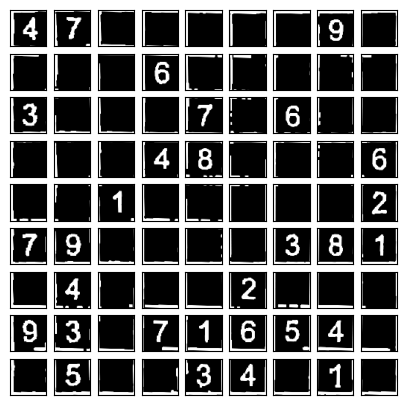

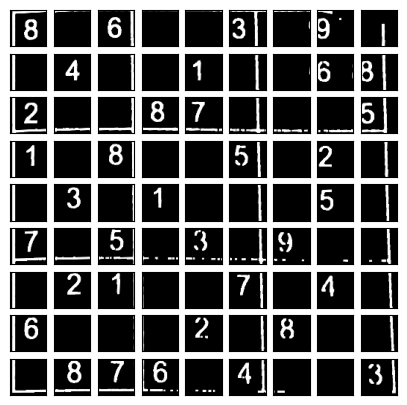

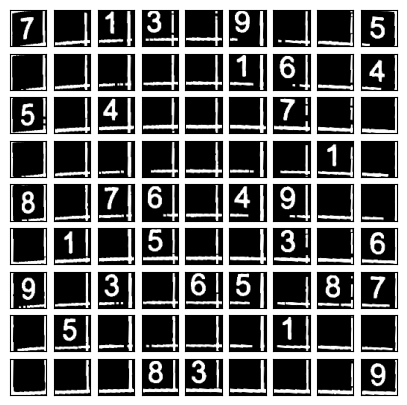

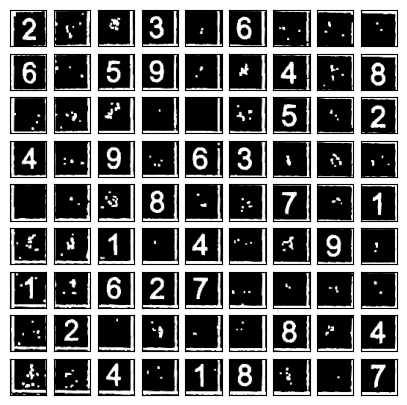

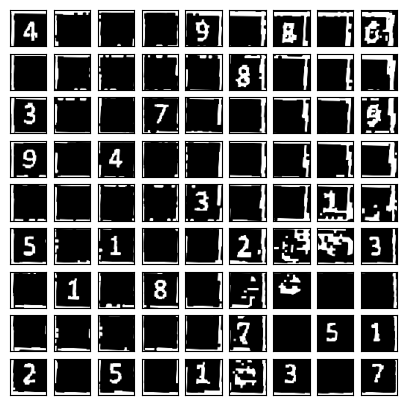

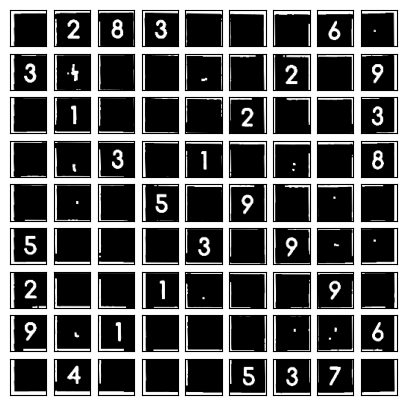

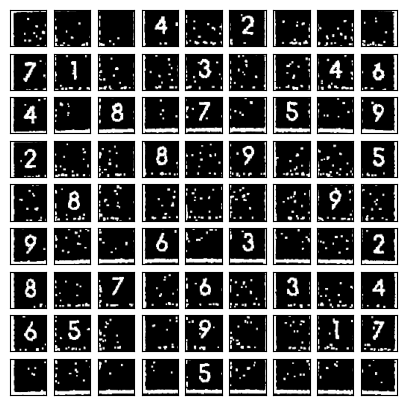

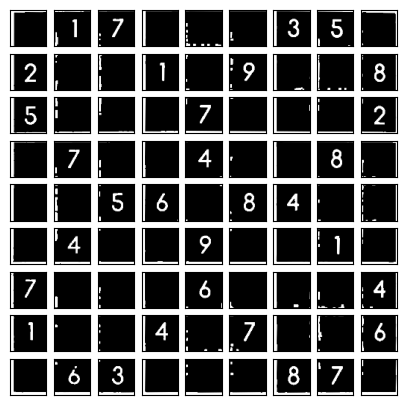

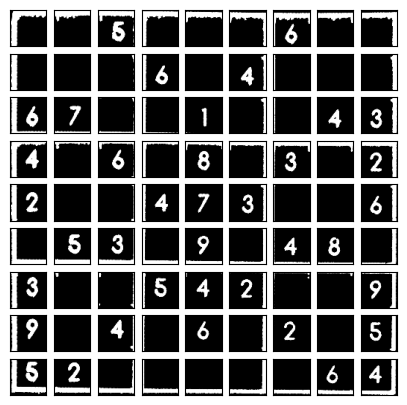

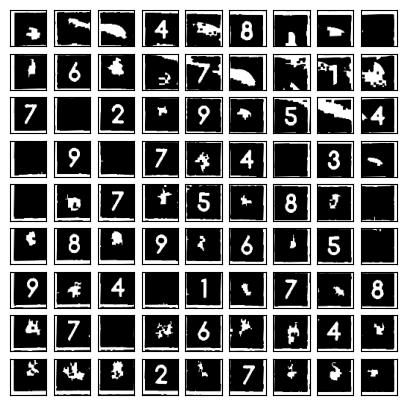

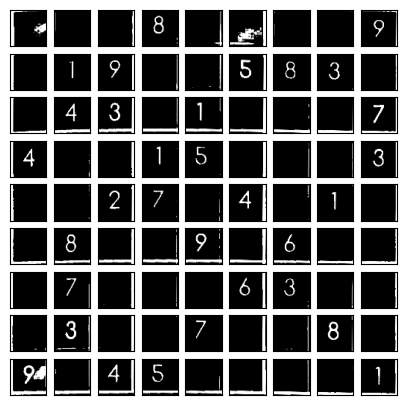

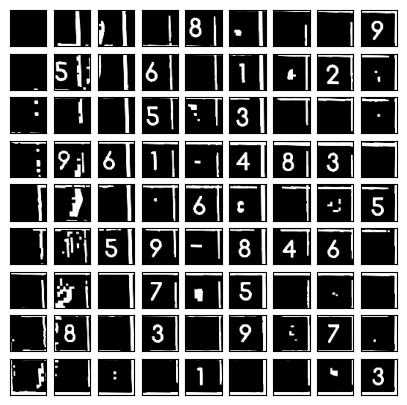

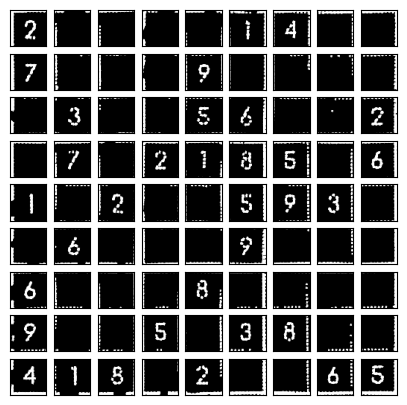

In [14]:
number_tiles = []
for x in range(NUM_IMAGES):
  try:
    number_tiles.append([])
    M = perspectiveImgs[x].shape[0] // 9
    N = perspectiveImgs[x].shape[1] // 9
    for i in range(9):
        number_tiles[x].append([])
        for j in range(9):
            tile = perspectiveImgs[x][i*M:(i+1)*M, j*N:(j+1)*N]
            number_tiles[x][i].append(tile)

    _, axes = plt.subplots(9, 9, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(number_tiles[x][i][j], cmap="gray");
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)
  except:
    pass

**Preprocessing of the tiles**

In [15]:
def preprocessTile(image):
  original_height, original_width = image.shape[:2]

  # Convert the image to grayscale if it is not already
  if len(image.shape) > 2 and image.shape[2] == 3:
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
      gray = image.copy()
  # Apply threshold to get the binary image
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

  # Apply CLAHE to the image
  img_clahe = clahe.apply(gray)
  darkened_image = cv2.addWeighted(img_clahe, 0.8, np.zeros(gray.shape, gray.dtype), 0, 50)

  _, thresh = cv2.threshold(darkened_image, 185, 255, cv2.THRESH_BINARY)
  return thresh


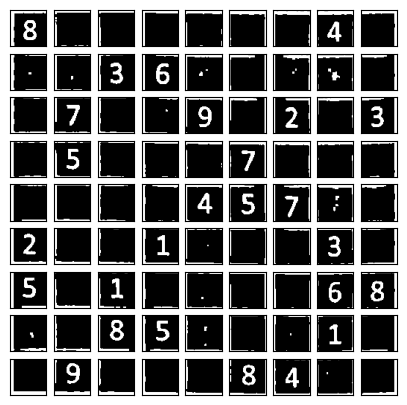

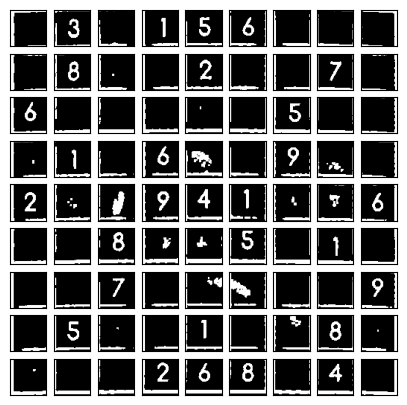

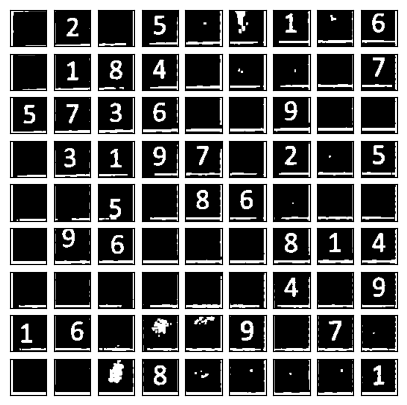

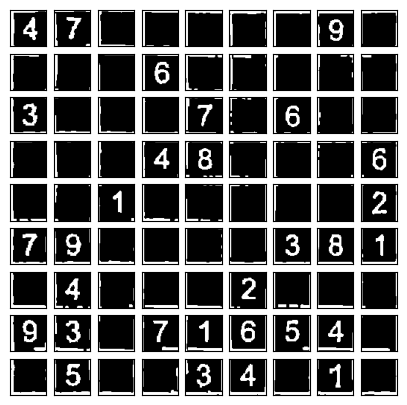

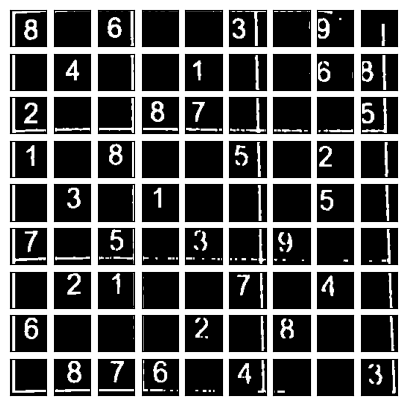

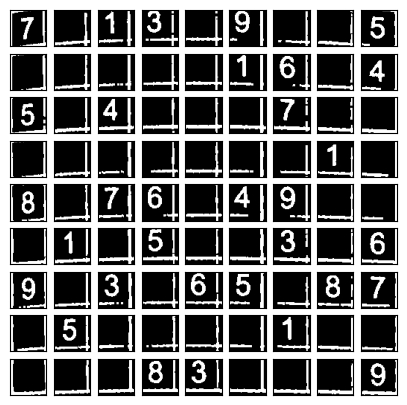

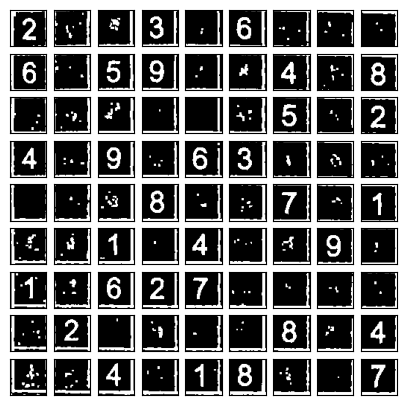

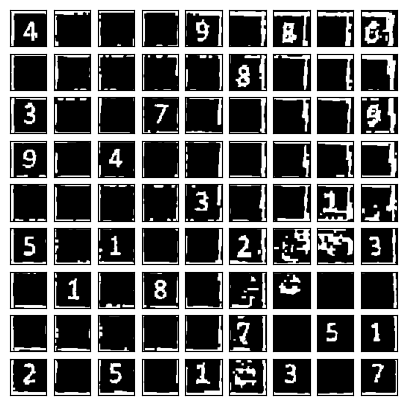

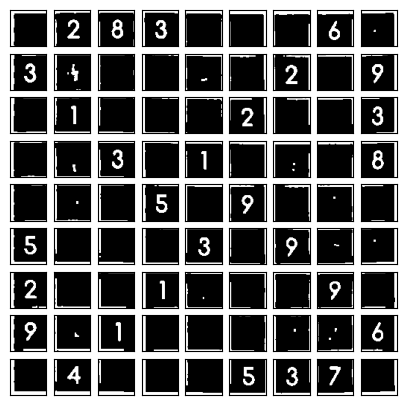

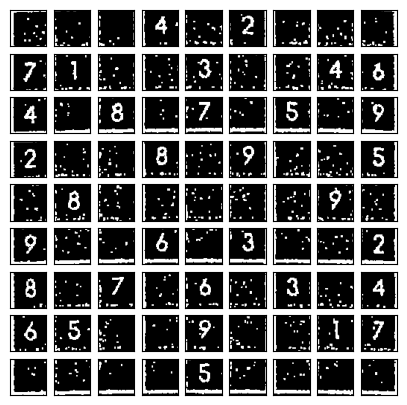

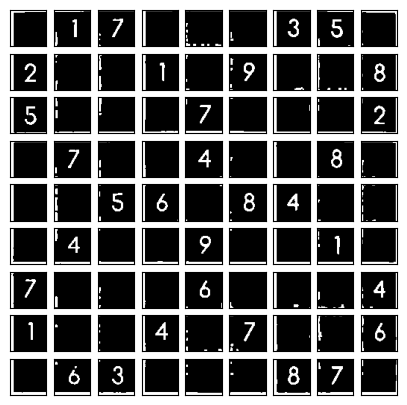

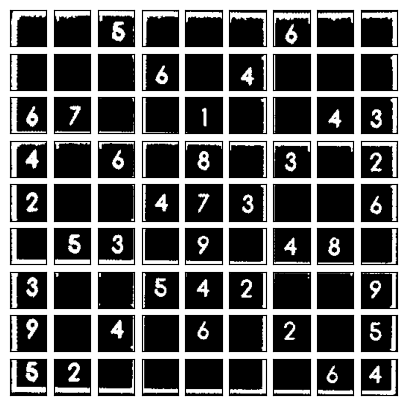

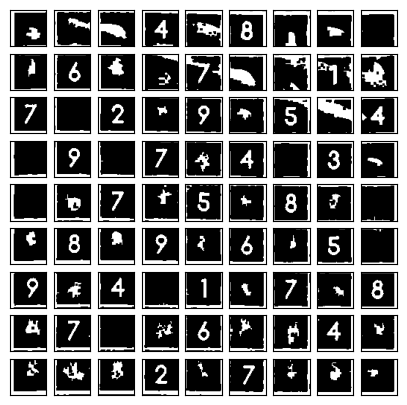

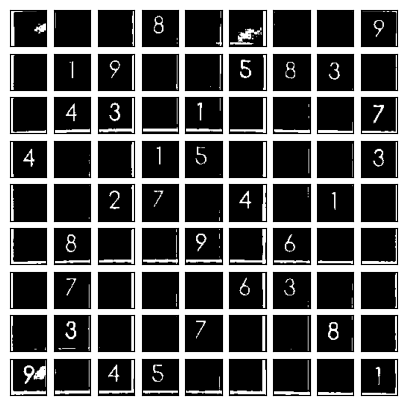

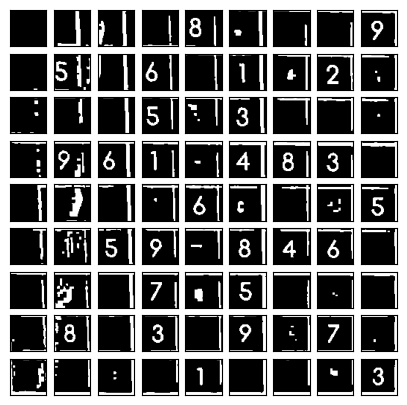

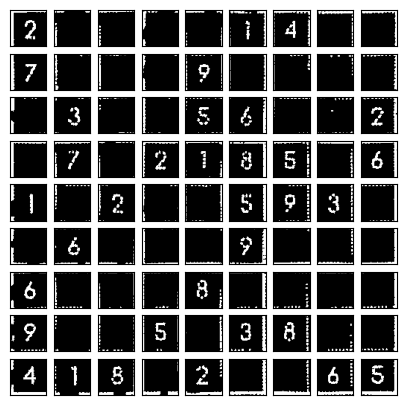

In [16]:
tiles = []
for x in range(NUM_IMAGES):
    tiles.append([])

    for i in range(9):
        tiles[x].append([])
        for j in range(9):
            tile = preprocessTile(number_tiles[x][i][j])
            count = np.count_nonzero(tile == 255)
            if count > 20:
                tiles[x][i].append(tile)
            else:
                img = cv2.medianBlur(number_tiles[x][i][j], 9)
                img = cv2.adaptiveThreshold(number_tiles[x][i][j],255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,41,1)
                tiles[x][i].append(tile)
    

    _, axes = plt.subplots(9, 9, figsize=(5, 5))
    for i, row in enumerate(axes):
        for j, col in enumerate(row):
            col.imshow(tiles[x][i][j], cmap="gray");
            col.get_xaxis().set_visible(False)
            col.get_yaxis().set_visible(False)


**Prepare Templates**

Number of 1's: 3
Number of 2's: 2
Number of 3's: 5
Number of 4's: 2
Number of 5's: 4
Number of 6's: 7
Number of 7's: 3
Number of 8's: 8
Number of 9's: 5
Number of noise templates: 10


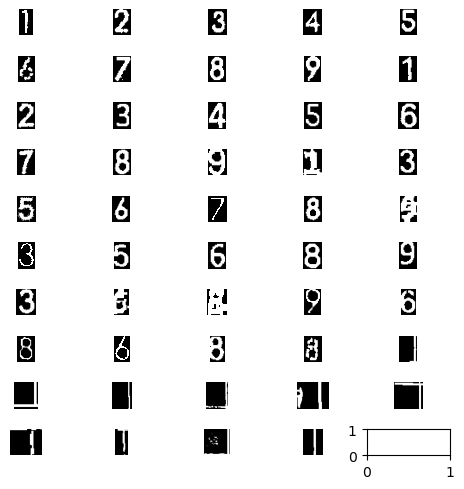

In [17]:
templates = []
templatesDigits = []

for i in range(9):
    for j in range(9):
        img = cv2.imread(f"digitsTemplates/{i}{j+1}.png", cv2.IMREAD_GRAYSCALE)
        if img is not None:
            _, thresh = cv2.threshold(img, 71, 255, cv2.THRESH_BINARY)
            templates.append(thresh)
            templatesDigits.append(j+1)
        else:
            continue
            

for i in range(10):
    img = cv2.imread(f"noiseTemplates/{i}{0}.png", cv2.IMREAD_GRAYSCALE)
    if img is not None:
        _, thresh = cv2.threshold(img, 71, 255, cv2.THRESH_BINARY)
        templates.append(thresh)
        templatesDigits.append(0)
        
    else:
        continue
        
print(f"Number of 1's: {templatesDigits.count(1)}")
print(f"Number of 2's: {templatesDigits.count(2)}")
print(f"Number of 3's: {templatesDigits.count(3)}")
print(f"Number of 4's: {templatesDigits.count(4)}")
print(f"Number of 5's: {templatesDigits.count(5)}")
print(f"Number of 6's: {templatesDigits.count(6)}")
print(f"Number of 7's: {templatesDigits.count(7)}")
print(f"Number of 8's: {templatesDigits.count(8)}")
print(f"Number of 9's: {templatesDigits.count(9)}")
print(f"Number of noise templates: {templatesDigits.count(0)}")

    
fig, axes = plt.subplots(10, 5, figsize=(5, 5))
axes = axes.flatten()
for i in range(len(templates)):
    axes[i].imshow(templates[i], cmap='gray')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


**Template Matching**

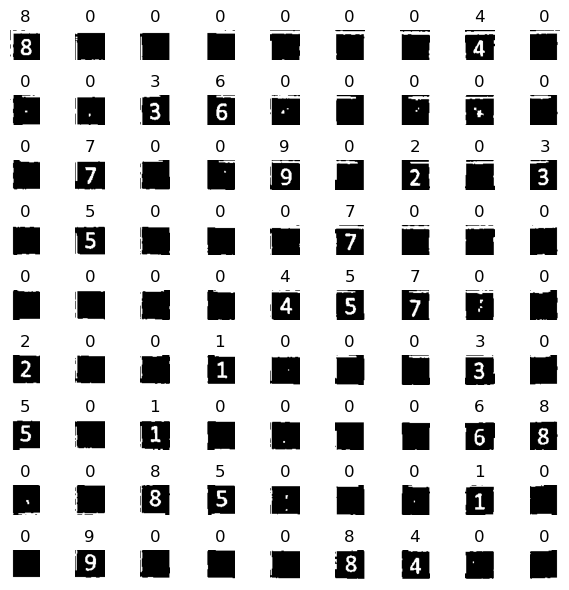

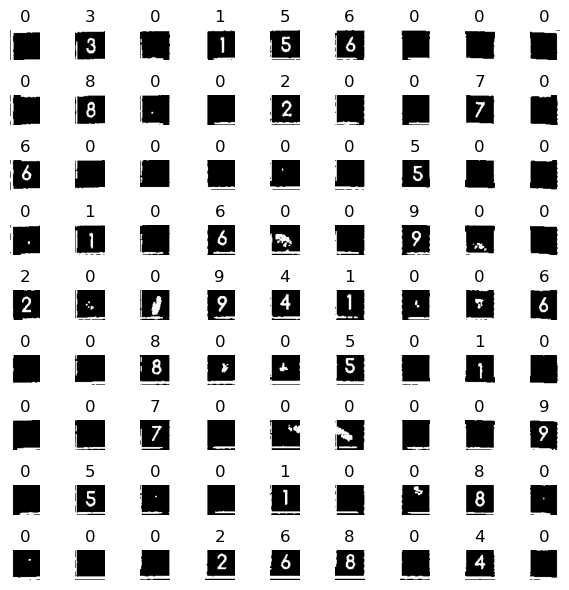

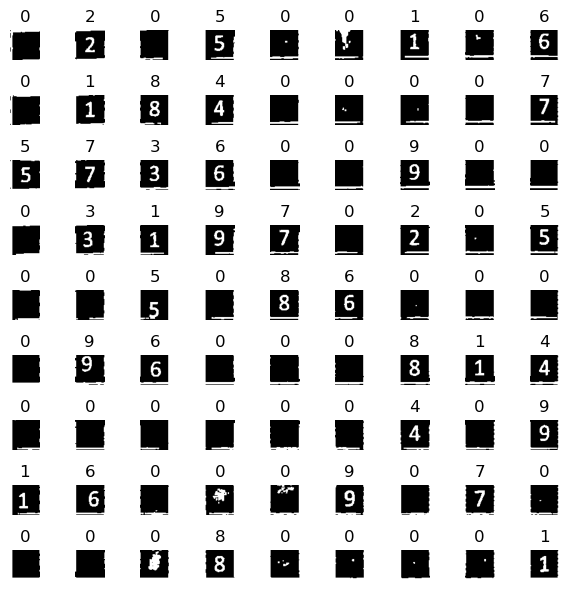

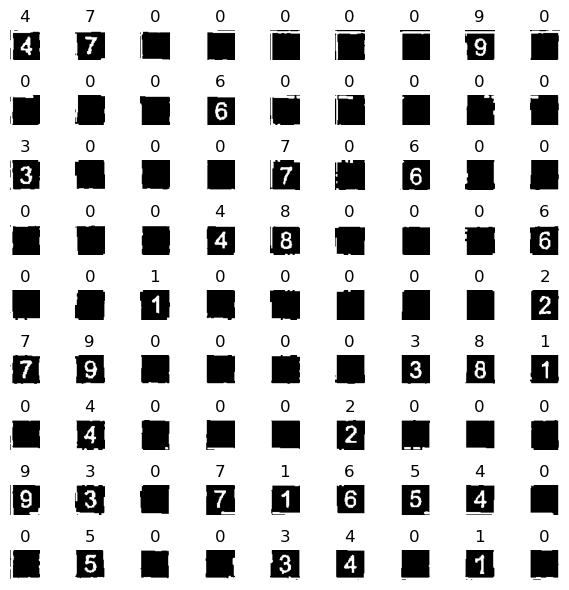

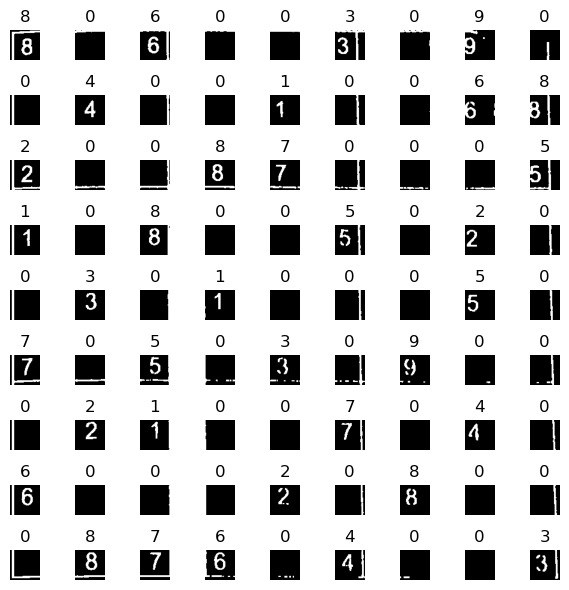

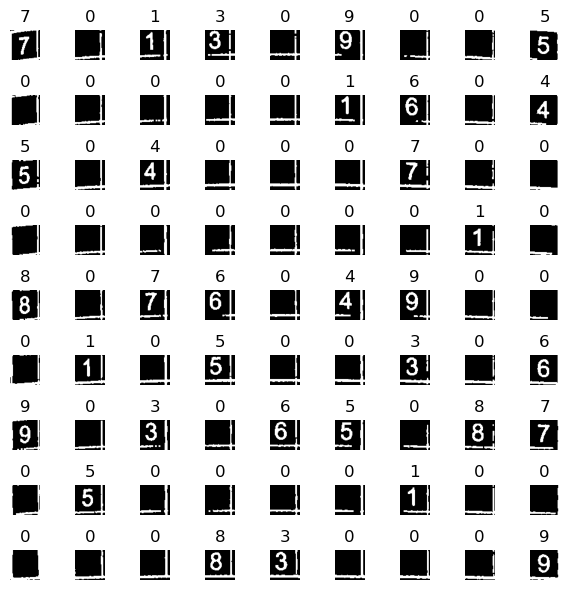

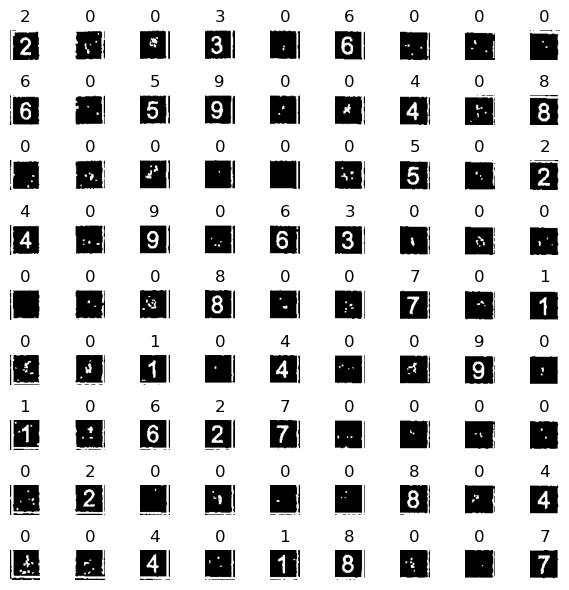

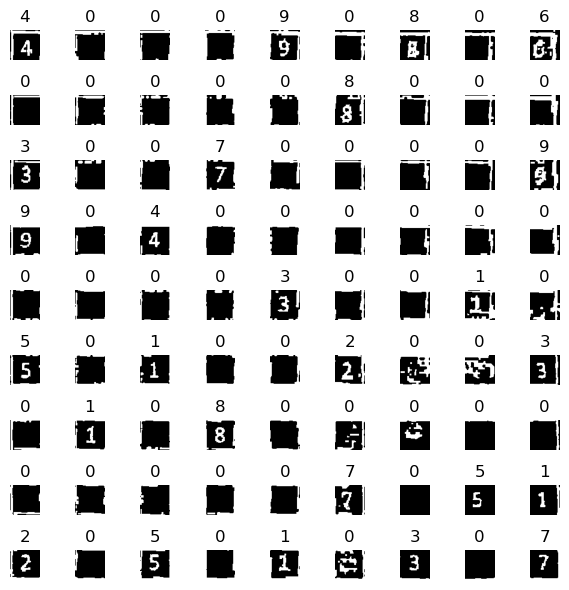

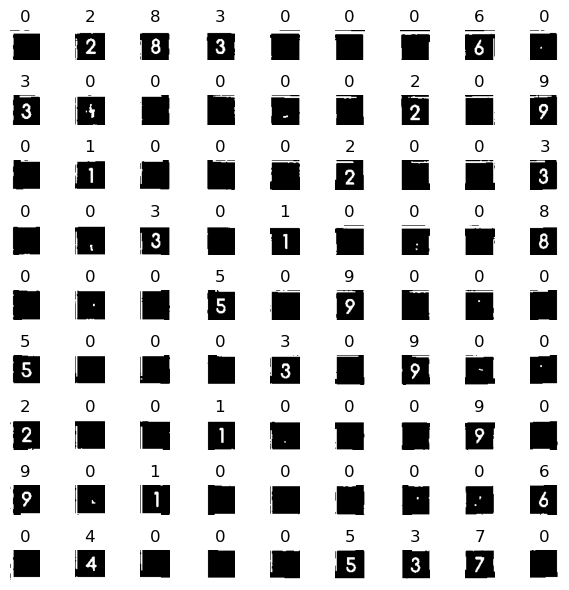

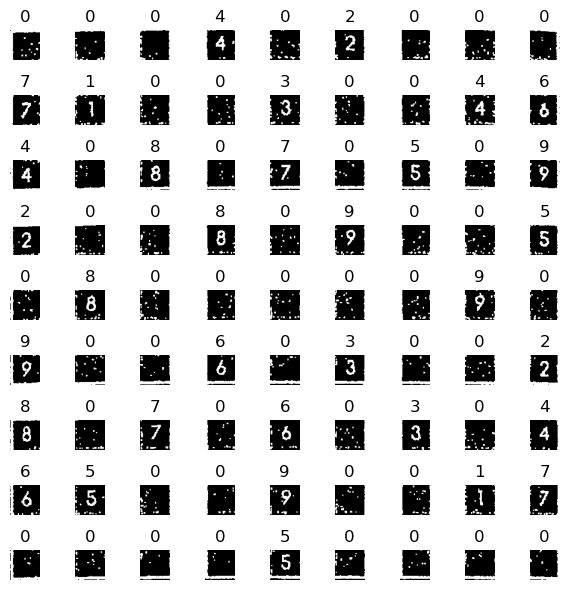

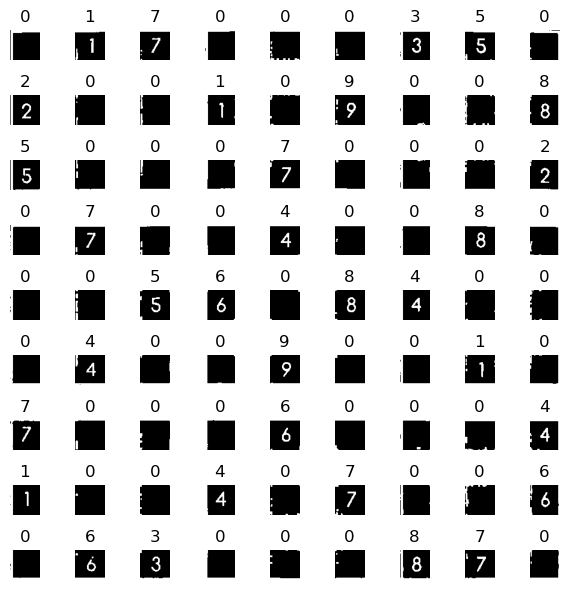

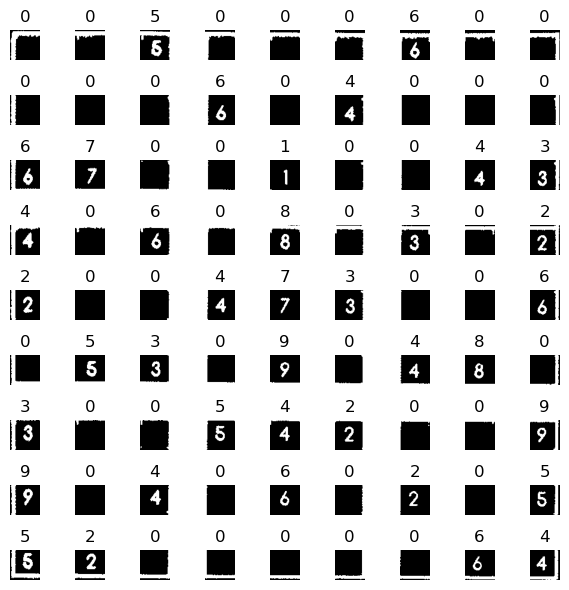

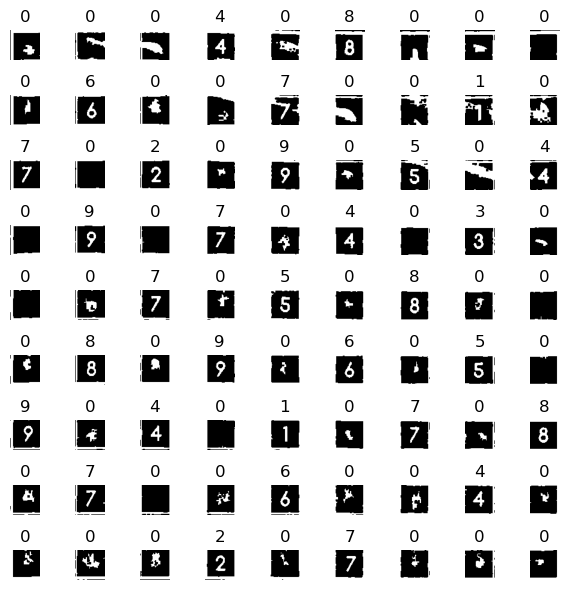

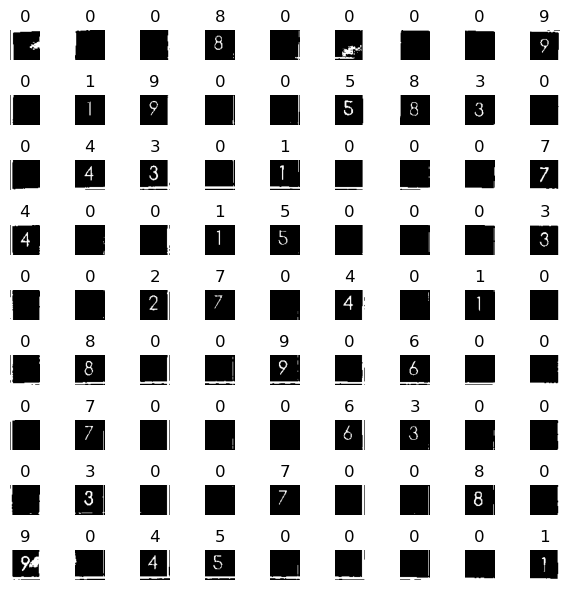

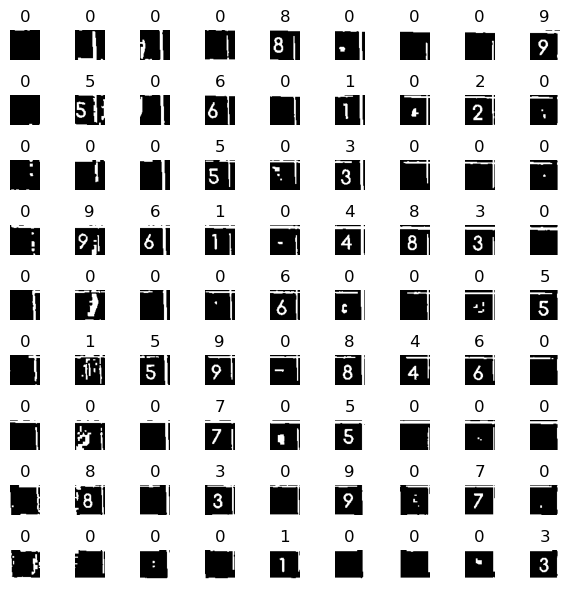

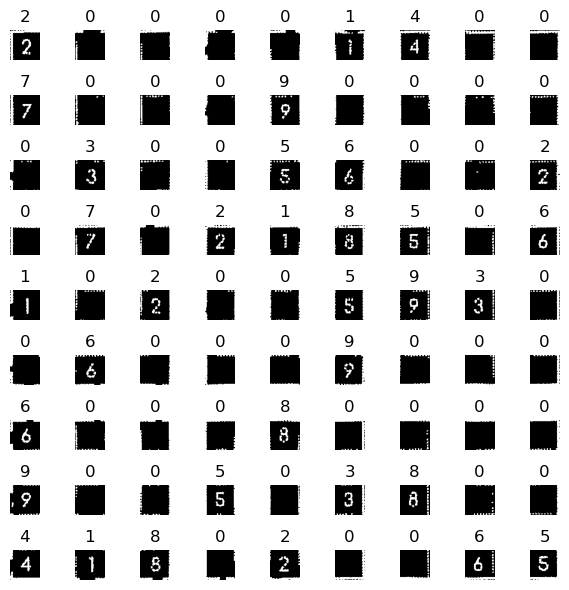

In [18]:
newPredictedTiles = []
board = []
for x in range(16):
        suduko = []  # Initialize an empty list for each Sudoku grid
        confidenceList = []
        counter = -1
        for i in range(9):
            rows = []  # Initialize an empty list for each row in the Sudoku grid
            for j in range(9):
                count = np.count_nonzero(tiles[x][i][j] == 255)
                max_confidence = -1
                matched_digit = None
                for z, template in enumerate(templates):
                    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
                    
                    result = cv2.matchTemplate(tiles[x][i][j], template, cv2.TM_CCOEFF_NORMED)
                    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

                    if max_val >= max_confidence:
                        if max_val <= 0.6:
                            matched_digit = 0
                        else:
                            max_confidence = max_val
                            matched_digit = templatesDigits[z]  # Since indices are 0-based
                rows.append(matched_digit)
                confidenceList.append(max_confidence)
                counter += 1
                newPredictedTiles.append(matched_digit)
                
                # Plotting the result
                plt.subplot(9, 9, i * 9 + j + 1)
                plt.imshow(tiles[x][i][j], cmap='gray')
                plt.title(matched_digit)
                plt.axis('off')
            suduko.append(rows)  # Append the completed row to the suduko grid
        board.append(suduko)  # Append the completed suduko grid to the board

        fig = plt.gcf()
        fig.set_size_inches(6, 6)
        plt.tight_layout()
        plt.show()

**Solving the Sudoku**

In [19]:
def textize_sudoku(board):
    sudoku_ocr_text = ''
    for i, row in enumerate(board):
        sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ ' if (i%3 == 0) else ' │           │           │           │ '
        sudoku_ocr_text += '\n'
        sudoku_ocr_text += ' │ '
        for j, cell in enumerate(row): sudoku_ocr_text += f"{cell if cell != 0 else ' '} {' ' if (j%3 != 2) else '│'} "
        sudoku_ocr_text += '\n'
    sudoku_ocr_text += ' ├───────────┼───────────┼───────────┤ '
    return sudoku_ocr_text

In [20]:
def find_next_empty_cell(board):
    for i in range(9):
        for j in range(9):
            if board[i][j] == 0:
                return (i, j)
    return None

def is_valid(board, num, row, col):
    for i in range(9):  # row and column checks
        if board[row][i] == num and col != i: return False
        if board[i][col] == num and row != i: return False

    # Check box
    box_row = (row // 3) * 3
    box_col = (col // 3) * 3
    for i in range(box_row, box_row + 3):
        for j in range(box_col, box_col + 3):
            if board[i][j] == num and (i, j) != (row, col):
                return False
    return True

def solve(board):
    empty_cell_pos = find_next_empty_cell(board)
    if empty_cell_pos == None: return True  # No empty cells; board is solved
    row, col = empty_cell_pos
    for num in range(1, 10):
        if is_valid(board, num, row, col):  # Find a valid value to proceed with
            board[row][col] = num  # 'num' seems valid (so far), proceed with it
            if solve(board): return True  # Try to solve the rest of the board
            board[row][col] = 0  # Couldn't continue? Then 'num' was wrong! :(
    return False

def solve_sudoku(board):
    sudoku_to_solve = np.copy(board)
    solve(sudoku_to_solve)
    solved_sudoku = []
    for i in range(9):
        solved_sudoku.append([])
        for j in range(9):
            solved_sudoku[i].append("\033[1m"+str(board[i][j])+"\033[0m" if (board[i][j] != 0) else "\033[91m"+str(sudoku_to_solve[i][j])+"\033[0m")
    return solved_sudoku

In [21]:
for i in range(16):
    print(f"\nSudoku Grid {i + 1}:")
    print(textize_sudoku(solve_sudoku(board[i])))


Sudoku Grid 1:
 ├───────────┼───────────┼───────────┤ 
 │ 8   1   2 │ 7   5   3 │ 6   4   9 │ 
 │           │           │           │ 
 │ 9   4   3 │ 6   8   2 │ 1   7   5 │ 
 │           │           │           │ 
 │ 6   7   5 │ 4   9   1 │ 2   8   3 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 1   5   4 │ 2   3   7 │ 8   9   6 │ 
 │           │           │           │ 
 │ 3   6   9 │ 8   4   5 │ 7   2   1 │ 
 │           │           │           │ 
 │ 2   8   7 │ 1   6   9 │ 5   3   4 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 5   2   1 │ 9   7   4 │ 3   6   8 │ 
 │           │           │           │ 
 │ 4   3   8 │ 5   2   6 │ 9   1   7 │ 
 │           │           │           │ 
 │ 7   9   6 │ 3   1   8 │ 4   5   2 │ 
 ├───────────┼───────────┼───────────┤ 

Sudoku Grid 2:
 ├───────────┼───────────┼───────────┤ 
 │ 7   3   2 │ 1   5   6 │ 4   9   8 │ 
 │           │           │           │ 
 │ 5   8   9 │ 4   2   3 │ 6   7   1 │ 
 │           │           │           │ 
 │ 6   4

 ├───────────┼───────────┼───────────┤ 
 │ 4   2   7 │ 1   9   5 │ 8   3   6 │ 
 │           │           │           │ 
 │ 1   6   9 │ 3   2   8 │ 4   7   5 │ 
 │           │           │           │ 
 │ 3   5   8 │ 7   6   4 │ 1   2   9 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 9   3   4 │ 5   8   1 │ 7   6   2 │ 
 │           │           │           │ 
 │ 6   7   2 │ 4   3   9 │ 5   1   8 │ 
 │           │           │           │ 
 │ 5   8   1 │ 6   7   2 │ 9   4   3 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 7   1   6 │ 8   5   3 │ 2   9   4 │ 
 │           │           │           │ 
 │ 8   9   3 │ 2   4   7 │ 6   5   1 │ 
 │           │           │           │ 
 │ 2   4   5 │ 9   1   6 │ 3   8   7 │ 
 ├───────────┼───────────┼───────────┤ 

Sudoku Grid 9:
 ├───────────┼───────────┼───────────┤ 
 │ 4   2   8 │ 3   9   7 │ 1   6   5 │ 
 │           │           │           │ 
 │ 3   5   7 │ 6   4   1 │ 2   8   9 │ 
 │           │           │           │ 
 │ 6   1   9 │ 8   5   2

 ├───────────┼───────────┼───────────┤ 
 │ 1   3   7 │ 4   8   2 │ 6   5   9 │ 
 │           │           │           │ 
 │ 4   5   9 │ 6   7   1 │ 3   2   8 │ 
 │           │           │           │ 
 │ 6   2   8 │ 5   9   3 │ 7   1   4 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 2   9   6 │ 1   5   4 │ 8   3   7 │ 
 │           │           │           │ 
 │ 8   4   3 │ 2   6   7 │ 1   9   5 │ 
 │           │           │           │ 
 │ 7   1   5 │ 9   3   8 │ 4   6   2 │ 
 ├───────────┼───────────┼───────────┤ 
 │ 3   6   4 │ 7   2   5 │ 9   8   1 │ 
 │           │           │           │ 
 │ 5   8   1 │ 3   4   9 │ 2   7   6 │ 
 │           │           │           │ 
 │ 9   7   2 │ 8   1   6 │ 5   4   3 │ 
 ├───────────┼───────────┼───────────┤ 

Sudoku Grid 16:
 ├───────────┼───────────┼───────────┤ 
 │ 2   9   6 │ 8   7   1 │ 4   5   3 │ 
 │           │           │           │ 
 │ 7   4   5 │ 3   9   2 │ 6   8   1 │ 
 │           │           │           │ 
 │ 8   3   1 │ 4   5   